In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [219]:
rush_yards_cols = [
    "yardline_100",
    "down",
    "goal_to_go",
    "ydstogo",
    'run_location', 
    'run_gap',
    "posteam_score",
    "defteam_score",
    "score_differential",
    "game_seconds_remaining",
    "wind",
    "temp",
]
player_cols = [
    "spread_line",
    "total_line",
    "carries_roll",
    "rushing_yards_roll",
    "yards_per_carry_roll",
    "rushing_yards_team_roll",
    "rushing_yards_opp_roll",
]

rush_yards_cols_small = [
    "yardline_100",
    "down",
    "goal_to_go",
    "ydstogo",
    "spread_line",
    "total_line",
    "yards_per_carry_roll",
    "rushing_yards_opp_roll",
]


In [3]:
class Block(nn.Module):
    def __init__(self, n_in=50, n_hidden=50, dropout_prob=0.2):
        super(Block, self).__init__()
        self.first_layers = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.LayerNorm(n_hidden),
            nn.LeakyReLU(0.1),
        )
        self.layers = nn.Sequential(
            nn.Linear(n_hidden, n_hidden),
            nn.LayerNorm(n_hidden),
            nn.LeakyReLU(0.1),
            nn.Dropout(p=dropout_prob),
            nn.Linear(n_hidden, n_hidden),
            nn.LayerNorm(n_hidden),
            nn.LeakyReLU(0.1),
        )

    def forward(self, x):
        x = self.first_layers(x)
        identity = x
        out = self.layers(x)
        out = out + identity

        return out


class masked_model(nn.Module):
    def __init__(self, n_in=11, n_out=109, n_hidden=50, dropout_prob=0.2):
        super(masked_model, self).__init__()

        self.block0 = Block(n_in, n_hidden * 4, dropout_prob=0.)
        self.block1 = Block(n_hidden * 4, n_hidden * 2, dropout_prob)
        self.block2 = Block(n_hidden * 2, n_hidden, dropout_prob)
        self.block3 = Block(n_hidden, n_hidden * 2, dropout_prob)
        self.yards_head = nn.Linear(n_hidden * 2, n_out)

    def forward(self, x):
        x = self.block0(x)
        x = self.block1(x)
        x = self.block2(x)
        yards = self.block3(x)
        yards = self.yards_head(yards)

        return yards

In [4]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim=118, output_dim=101, embed_dim=512, nhead=4, num_layers=5, dropout=0.1):
        super(TransformerModel, self).__init__()
        
        # Input embedding
        self.input_proj = nn.Linear(input_dim, embed_dim)
        
        # Transformer Encoder with 5 layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=nhead,
            dim_feedforward=embed_dim * 4,
            dropout=dropout,
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output projection
        self.output_proj = nn.Linear(embed_dim, output_dim)
    
    def forward(self, x):
        # Handle input shape: (batch_size, input_dim)
        if x.dim() == 2:
            x = x.unsqueeze(1)  # Add sequence dimension: (batch_size, 1, input_dim)
        # Project input to embedding dimension
        x = self.input_proj(x)  # (batch_size, seq_length, embed_dim)
        # Permute for transformer compatibility (seq_length, batch_size, embed_dim)
        x = x.permute(1, 0, 2)
        # Apply transformer encoder
        x = self.transformer_encoder(x)  # (seq_length, batch_size, embed_dim)
        # Permute back (batch_size, seq_length, embed_dim)
        x = x.permute(1, 0, 2)
        # Remove sequence dimension if seq_length == 1
        x = x.squeeze(1)
        # Apply output projection
        x = self.output_proj(x)  # (batch_size, output_dim)
        
        return x


In [5]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

rushes = pd.read_parquet("nn_rush_data.parquet")
rushes['run_location'] = rushes['run_location'].apply(lambda x: 1 if x == 'middle' else 0)
rushes['run_gap'] = rushes['run_gap'].apply(lambda x:0 if x == 'guard' else 1 if x == 'tackle' else '2' if x == 'end' else 3)
rushes["end_yardline"] = rushes["yardline_100"] - rushes["yards_gained"]
#rush_yards_cols = rush_yards_cols_small
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X = rushes[rush_yards_cols].copy()
train_yards = rushes["yards_shifted"]
train_TD = rushes["touchdown"]
train_end = rushes["end_yardline"]

scaler = MinMaxScaler()
X_ = scaler.fit_transform(X)
X_ = torch.tensor(X_, dtype=torch.float32)
X = rushes[rush_yards_cols]

In [6]:
rushes[rush_yards_cols].iloc[4]

yardline_100                19.0
down                         1.0
goal_to_go                     0
ydstogo                     10.0
run_location                   0
run_gap                        2
posteam_score                0.0
defteam_score                0.0
score_differential           0.0
game_seconds_remaining    3326.0
wind                         3.0
temp                        70.0
Name: 4, dtype: object

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

def custom_encoding(targets, num_classes):
    """
    Encodes targets into a cumulative encoding format.

    Args:
        targets (torch.Tensor): A tensor of target indices, shape (batch_size,).
        num_classes (int): Total number of classes.

    Returns:
        torch.Tensor: Encoded tensor, shape (batch_size, num_classes).
    """
    class_range = torch.arange(num_classes, device=targets.device).unsqueeze(0)
    encoded = (class_range <= targets.unsqueeze(1)).int()
    encoded[encoded < 1] = 0
    return encoded


def df_to_X(df, cols=rush_yards_cols, fit=False):
    #ydl = custom_encoding(torch.tensor(df['yardline_100'].values),101).to(device) - 1
    ydl = custom_encoding(torch.tensor(df['yardline_100'].values),101) - 1 + custom_encoding(torch.tensor(df['yardline_100'].values - df['ydstogo'].values),101)
    #ydl = custom_encoding(torch.tensor(df['yardline_100'].values - df['ydstogo'].values),101).to(device)
    X = df[cols]
    X = scaler.transform(X)
    X = torch.tensor(X, dtype=torch.float32)
    X = torch.cat((X,ydl), dim=1).to(device)
    return X



df_to_X(rushes)[0]


tensor([ 0.7857,  0.3333,  0.0000,  0.2000,  0.0000,  0.6667,  0.0000,  0.0000,
         0.5045,  0.9900,  0.0423,  0.7379,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.00

In [8]:
def make_syn_data(df):
    syn = rushes.loc[
        (rushes.yardline_100.between(15, 90)) & (rushes.end_yardline > 4),
        rush_yards_cols + ["end_yardline", "yards_gained"],
    ].copy()
    #syn["yardline_100"] = syn["yardline_100"] + np.random.randint(-5, 5, len(syn))
    #syn["end_yardline"] = syn["yardline_100"] - syn["yards_gained"]
    #syn["end_yardline"] = syn["end_yardline"].clip(0, 100)
    x = syn[rush_yards_cols]
    y = syn["end_yardline"]
    return x, y


syn = make_syn_data(rushes)
[_.shape for _ in syn]

[(179418, 12), (179418,)]

In [9]:
def make_syn_tds(df):
    syn = rushes[rush_yards_cols + ["end_yardline", "yards_gained"]
    ].copy()
    syn["yardline_100"] = syn["yardline_100"] + np.random.randint(-5, 5, len(syn))
    syn["yardline_100"] = syn["yardline_100"].clip(1, 99)
    syn["end_yardline"] = 0
    #syn["end_yardline"] = syn["end_yardline"].clip(0, 100)
    x = syn[rush_yards_cols]
    y = syn["end_yardline"]
    return x, y

In [153]:
def train_custom_model(X, yards, epochs=10, batch_size=256, model=None, loss_weights= [4,2,0.4]):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #loss_weights = torch.ones(101, device=device)
    #loss_weights[0] = 1.1
    ydl = torch.tensor(X['yardline_100'].values,dtype=torch.float).to(device)
    X = df_to_X(X, fit=True)


    n_features = 113
    n_output = 101
    n_hidden = 256

    y = torch.tensor(yards, dtype=torch.long).to(device)
    class_idx = torch.ones(n_output, dtype=torch.float32, device=device).cumsum(
        0
    ) -1  # for regression. subtract one so first idx is 0 yard line
    if not model:
        model = masked_model(n_features, n_output, n_hidden).to(device)
        model.train()
        #model=TransformerModel().to(device)
    criterion_yards = nn.CrossEntropyLoss()
    reg_criterion = nn.MSELoss()  # only useful for yards gained
    l1_criterion = nn.L1Loss()

    lr = 1e-4
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=lr/100)

    num_samples = X.size(0)
    print("num_samples:", num_samples)
    indices = torch.randperm(num_samples, device=device)

    split = num_samples // 10  # 20% test data
    test_indices = indices[:split]
    train_indices = indices[split:]

    Xtr = X[train_indices].to(device)
    Xtst = X[test_indices].to(device)
    train_yards = y[train_indices].to(device)
    test_yards = y[test_indices].to(device)
    trainydl = ydl[train_indices].to(device)
    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(Xtr.size(0))
        epoch_loss = 0
        epoch_reg_loss = 0
        epoch_l1_loss = 0
        epoch_yard_loss = 0


        for i in range(0, Xtr.size(0), batch_size):
            indices = permutation[i : i + batch_size]
            batch_x = Xtr[indices]
            batch_yards = train_yards[indices]
            batch_ydl = trainydl[indices]
            optimizer.zero_grad()
            yards_pred = model(batch_x)  # Shape: [batch_size, 100]
            loss_yards = criterion_yards(yards_pred, batch_yards)
            reg_targets = batch_ydl - (F.softmax(yards_pred, dim=1) * class_idx).sum(1)
            #reg_targets = (F.softmax(yards_pred, dim=1) * class_idx).sum(1)

            reg_actual = batch_ydl - batch_yards.float()
            if epoch == 52052463:
                print(f'{reg_targets[0:5]},batch={ reg_actual[0:5]}')
                raise Exception
            reg_loss = reg_criterion(reg_targets,reg_actual)
            l1_loss = l1_criterion(reg_targets,reg_actual)
            loss = (loss_weights[0] * loss_yards) + (loss_weights[1] *  reg_loss) + (loss_weights[2] * l1_loss)
            loss.backward()
            optimizer.step()

            epoch_loss += loss_yards.item()
            epoch_reg_loss += reg_loss.item()
            epoch_l1_loss += l1_loss.item()
            epoch_yard_loss += loss_yards.item()



        print(f"Epoch {epoch+1}/{epochs}, yard: {epoch_loss/len(Xtr):.4f}, reg: {epoch_reg_loss/len(Xtr):.4f}. l1: {epoch_l1_loss/len(Xtr):.4f}")

        # Evaluation on the test set
    model.eval()
    with torch.no_grad():
        test_preds = model(Xtst)  # Shape: [num_samples, 100]
        yard_loss = criterion_yards(test_preds, test_yards).mean().item()
        accuracy = (test_preds.argmax(dim=1) == test_yards).float().mean().item()
    print(f"Test Loss: {yard_loss:.4f}, Test Accuracy: {accuracy:.4f}")

    return model


In [168]:
rush_yards_model = train_custom_model(X, train_end, epochs=10, model=rush_yards_model)
'''num_samples: 211852
Epoch 1/5, yard: 0.0109, reg: 0.1503. l1: 0.0146
Epoch 2/5, yard: 0.0109, reg: 0.1503. l1: 0.0146
Epoch 3/5, yard: 0.0109, reg: 0.1501. l1: 0.0146
Epoch 4/5, yard: 0.0109, reg: 0.1501. l1: 0.0146
Epoch 5/5, yard: 0.0109, reg: 0.1501. l1: 0.0146
Test Loss: 2.7905, Test Accuracy: 0.1367'''

num_samples: 211852
Epoch 1/10, yard: 0.0110, reg: 0.1519. l1: 0.0148
Epoch 2/10, yard: 0.0110, reg: 0.1518. l1: 0.0148
Epoch 3/10, yard: 0.0110, reg: 0.1518. l1: 0.0148
Epoch 4/10, yard: 0.0110, reg: 0.1518. l1: 0.0148
Epoch 5/10, yard: 0.0110, reg: 0.1517. l1: 0.0148
Epoch 6/10, yard: 0.0110, reg: 0.1518. l1: 0.0148
Epoch 7/10, yard: 0.0110, reg: 0.1517. l1: 0.0148
Epoch 8/10, yard: 0.0110, reg: 0.1517. l1: 0.0148
Epoch 9/10, yard: 0.0110, reg: 0.1517. l1: 0.0148
Epoch 10/10, yard: 0.0110, reg: 0.1517. l1: 0.0148
Test Loss: 2.8284, Test Accuracy: 0.1399


'num_samples: 211852\nEpoch 1/5, yard: 0.0109, reg: 0.1503. l1: 0.0146\nEpoch 2/5, yard: 0.0109, reg: 0.1503. l1: 0.0146\nEpoch 3/5, yard: 0.0109, reg: 0.1501. l1: 0.0146\nEpoch 4/5, yard: 0.0109, reg: 0.1501. l1: 0.0146\nEpoch 5/5, yard: 0.0109, reg: 0.1501. l1: 0.0146\nTest Loss: 2.7905, Test Accuracy: 0.1367'

In [171]:
rush_yards_cols

['yardline_100',
 'down',
 'goal_to_go',
 'ydstogo',
 'run_location',
 'run_gap',
 'posteam_score',
 'defteam_score',
 'score_differential',
 'game_seconds_remaining',
 'wind',
 'temp']

In [ ]:
for i in range(0):
    print(i)
    x_syn, y_syn = make_syn_tds(rushes)
    y_syn = pd.Series(y_syn).values
    rush_yards_model = train_custom_model(
        x_syn, y_syn, epochs=1, model=rush_yards_model
    )

0
num_samples: 211852


KeyboardInterrupt: 

In [ ]:
rush_yards_model = train_custom_model(X, train_end, epochs=5, model=rush_yards_model)
for i in range(10):
    print(i)
    x_syn, y_syn = make_syn_data(rushes.loc[rushes.touchdown==1])
    y_syn = pd.Series(y_syn).values
    rush_yards_model = train_custom_model(
        x_syn, y_syn, epochs=1, model=rush_yards_model
    )

rush_yards_model = train_custom_model(X, train_end, epochs=15, model=rush_yards_model)
'''Epoch 3/3, yard: 0.0107, reg: 0.1407. l1: 0.0142
Test Loss: 2.7409, Test Accuracy: 0.1490'''

num_samples: 211852
Epoch 1/5, yard: 0.0118, reg: 0.1561. l1: 0.0152
Epoch 2/5, yard: 0.0115, reg: 0.1551. l1: 0.0151
Epoch 3/5, yard: 0.0114, reg: 0.1548. l1: 0.0151
Epoch 4/5, yard: 0.0113, reg: 0.1541. l1: 0.0150
Epoch 5/5, yard: 0.0113, reg: 0.1542. l1: 0.0150
Test Loss: 2.8681, Test Accuracy: 0.1283
0
num_samples: 179418
Epoch 1/1, yard: 0.0116, reg: 0.1294. l1: 0.0148
Test Loss: 2.9647, Test Accuracy: 0.1033
1
num_samples: 179418
Epoch 1/1, yard: 0.0115, reg: 0.1298. l1: 0.0148
Test Loss: 2.9355, Test Accuracy: 0.1163
2
num_samples: 179418
Epoch 1/1, yard: 0.0115, reg: 0.1296. l1: 0.0148
Test Loss: 2.9533, Test Accuracy: 0.1045
3
num_samples: 179418
Epoch 1/1, yard: 0.0115, reg: 0.1289. l1: 0.0147
Test Loss: 2.9305, Test Accuracy: 0.1178
4
num_samples: 179418
Epoch 1/1, yard: 0.0115, reg: 0.1296. l1: 0.0147
Test Loss: 2.9208, Test Accuracy: 0.1169
5
num_samples: 179418
Epoch 1/1, yard: 0.0115, reg: 0.1292. l1: 0.0147
Test Loss: 2.9118, Test Accuracy: 0.1163
6
num_samples: 179418


'Epoch 3/3, yard: 0.0107, reg: 0.1407. l1: 0.0142\nTest Loss: 2.7409, Test Accuracy: 0.1490'

In [383]:
'''num_samples: 211852
Epoch 1/8, yard Loss: 0.0038
Epoch 2/8, yard Loss: 0.0029
Epoch 3/8, yard Loss: 0.0028
Epoch 4/8, yard Loss: 0.0028
Epoch 5/8, yard Loss: 0.0028
Epoch 6/8, yard Loss: 0.0028
Epoch 7/8, yard Loss: 0.0028
Epoch 8/8, yard Loss: 0.0028
Test Loss: 2.8552, Test Accuracy: 0.1247
pyramid n_in, flat reg + cross entropy
'''

'''num_samples: 211852
num_samples: 211852
Epoch 1/8, yard Loss: 0.0029
Epoch 2/8, yard Loss: 0.0028
Epoch 3/8, yard Loss: 0.0028
Epoch 4/8, yard Loss: 0.0028
Epoch 5/8, yard Loss: 0.0028
Epoch 6/8, yard Loss: 0.0028
Epoch 7/8, yard Loss: 0.0028
Epoch 8/8, yard Loss: 0.0028
Test Loss: 2.8370, Test Accuracy: 0.1253
MSELoss with reg to yards gained not yardline
'''

'num_samples: 211852\nnum_samples: 211852\nEpoch 1/8, yard Loss: 0.0029\nEpoch 2/8, yard Loss: 0.0028\nEpoch 3/8, yard Loss: 0.0028\nEpoch 4/8, yard Loss: 0.0028\nEpoch 5/8, yard Loss: 0.0028\nEpoch 6/8, yard Loss: 0.0028\nEpoch 7/8, yard Loss: 0.0028\nEpoch 8/8, yard Loss: 0.0028\nTest Loss: 2.8370, Test Accuracy: 0.1253\nMSELoss with reg to yards gained not yardline\n'

In [155]:
rush_yards_model.eval()
for name, param in rush_yards_model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.grad.norm().item():.4f}")

block0.first_layers.0.weight: 8.0162
block0.first_layers.0.bias: 0.8007
block0.first_layers.1.weight: 0.7236
block0.first_layers.1.bias: 0.6827
block0.layers.0.weight: 0.5709
block0.layers.0.bias: 0.0246
block0.layers.1.weight: 0.1556
block0.layers.1.bias: 0.1068
block0.layers.4.weight: 0.6934
block0.layers.4.bias: 0.0287
block0.layers.5.weight: 0.2261
block0.layers.5.bias: 0.3774
block1.first_layers.0.weight: 2.5444
block1.first_layers.0.bias: 0.0975
block1.first_layers.1.weight: 0.7950
block1.first_layers.1.bias: 0.5826
block1.layers.0.weight: 0.0751
block1.layers.0.bias: 0.0035
block1.layers.1.weight: 0.0280
block1.layers.1.bias: 0.0199
block1.layers.4.weight: 0.3590
block1.layers.4.bias: 0.0169
block1.layers.5.weight: 0.0918
block1.layers.5.bias: 0.2328
block2.first_layers.0.weight: 4.0115
block2.first_layers.0.bias: 0.2080
block2.first_layers.1.weight: 0.8911
block2.first_layers.1.bias: 0.7704
block2.layers.0.weight: 0.2058
block2.layers.0.bias: 0.0167
block2.layers.1.weight: 0.06

22
data: 4.281, network:3.836


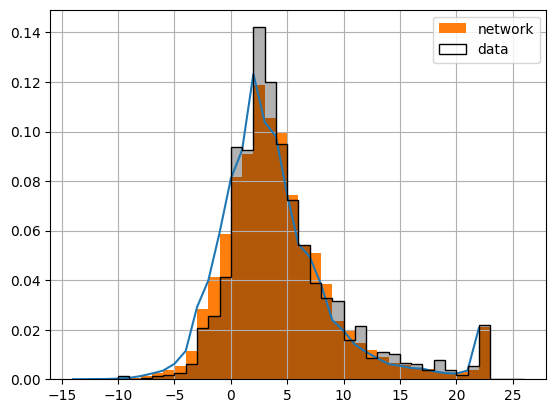

In [211]:
def sample_custom(ydl, num_samples):
    data = (
        rushes.loc[rushes.yardline_100 == ydl].sample(num_samples, replace=True).copy()
    )
    data['down'] = 4
    data['ydstogo'] = 1
    x_ = df_to_X(data)
    o = rush_yards_model(x_.to("cuda"))
    yard_probs = F.softmax(o, dim=1).detach().to("cpu")
    return yard_probs


def plot_ydl(ydl):

    print(ydl)
    yard_probs = sample_custom(ydl, 10000)
    yard_probs = yard_probs.mean(dim=0)


    sample = ydl - torch.multinomial(yard_probs, 30000, replacement=True)
    plt.plot(range(-14,ydl+1),yard_probs.flip((0))[101-ydl-15:])
    bins = range(-10, ydl+5)
    plt.hist(sample, density=True, bins=bins, label="network")


    testy = rushes.loc[rushes.yardline_100 == ydl, "yards_gained"].copy()
    testy.hist(
        density=True, alpha=1, bins=bins, label="data", histtype="step", color="black"
    )
    testy.hist(density=True, alpha=0.3, bins=bins, color="black")
    plt.legend()
    #plt.show()
    print(f"data: {testy.mean():.4}, network:{sample.double().mean():.4}")

for i in [22]:
    plot_ydl(i)

''

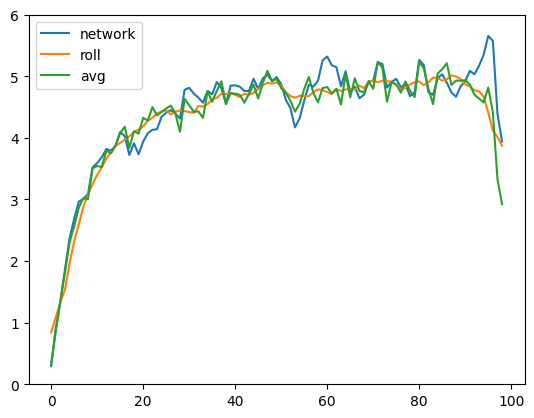

In [216]:
class_idx = torch.ones(101, dtype=torch.float32).cumsum(
    0
) -1

def sample_avg(ydl, num_samples):
    data = (
        rushes.loc[rushes.yardline_100 == ydl].sample(num_samples, replace=True).copy()
    )
    x_ = df_to_X(data)
    o = rush_yards_model(x_.to("cuda"))
    yard_probs = F.softmax(o, dim=1).detach().to("cpu")
    return yard_probs

a = []
tds = []
for ydl in range(1,100):
    s = sample_avg(ydl, 10000)
    td = s.sum(0)[0].item()
    tds.append(td)
    s = s * class_idx
    avg = ydl - s.sum(1).mean()
    a.append(avg)

vals  = [float(_) for _ in a]
plt.plot(vals,label='network')
df = rushes.groupby('yardline_100')['yards_gained'].mean().reset_index()
df['roll'] = df['yards_gained'].rolling(6, min_periods=1, center=True).mean()
plt.plot(df['roll'], label='roll')
plt.plot(df['yards_gained'], label='avg')
plt.legend()
plt.ylim((0,6))
''

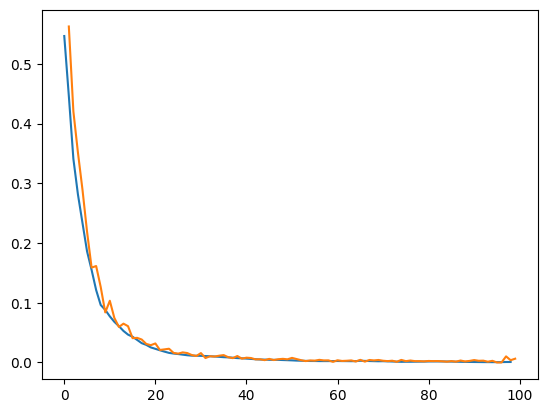

In [217]:
plt.plot([t / 10000 for t in tds])
plt.plot(rushes.groupby('yardline_100')['touchdown'].mean())

# general yard dist -> player yard dist

In [221]:
rushes[player_cols]

,spread_line,total_line,carries_roll,rushing_yards_roll,yards_per_carry_roll,rushing_yards_team_roll,rushing_yards_opp_roll
0,-3.0,39.5,0.000000,0.000000,0.000000,0.999984,1.000146
1,-3.0,39.5,0.000000,0.000000,0.000000,0.999984,1.000146
2,-3.0,39.5,0.000000,0.000000,0.000000,0.999984,1.000146
3,-3.0,39.5,0.000000,0.000000,0.000000,0.999984,1.000146
4,3.0,39.5,0.000000,0.000000,0.000000,0.758916,0.759040
...,...,...,...,...,...,...,...
212275,-8.0,40.5,22.019843,92.062827,4.180903,1.089268,0.886609
212276,8.0,40.5,14.985753,61.015051,4.071537,1.093094,0.912123
212277,-8.0,40.5,22.019843,92.062827,4.180903,1.089268,0.886609
212278,8.0,40.5,14.985753,61.015051,4.071537,1.093094,0.912123


In [222]:
class Block(nn.Module):
    def __init__(self, n_in=50, n_hidden=50, dropout_prob=0.2):
        super(Block, self).__init__()
        self.first_layers = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.LayerNorm(n_hidden),
            nn.LeakyReLU(0.1),
        )
        self.layers = nn.Sequential(
            nn.Linear(n_hidden, n_hidden),
            nn.LayerNorm(n_hidden),
            nn.LeakyReLU(0.1),
            nn.Dropout(p=dropout_prob),
            nn.Linear(n_hidden, n_hidden),
            nn.LayerNorm(n_hidden),
            nn.LeakyReLU(0.1),
        )

    def forward(self, x):
        x = self.first_layers(x)
        identity = x
        out = self.layers(x)
        out = out + identity

        return out


class player_model(nn.Module):
    def __init__(self, n_in=11, n_out=101, n_hidden=50, dropout_prob=0.2):
        super(player_model, self).__init__()

        self.block0 = Block(n_in, n_hidden * 4, dropout_prob=0.)
        self.block1 = Block(n_hidden * 4, n_hidden * 2, dropout_prob)
        self.block2 = Block(n_hidden * 2, n_hidden, dropout_prob)
        self.block3 = Block(n_hidden, n_hidden * 2, dropout_prob)
        self.yards_head = nn.Linear(n_hidden * 2, n_out)

    def forward(self, x):
        x = self.block0(x)
        x = self.block1(x)
        x = self.block2(x)
        yards = self.block3(x)
        yards = self.yards_head(yards)

        return yards

In [244]:
tst = rushes.sample(100).copy()
tst

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,rushing_first_downs_roll,receptions_roll,targets_roll,receiving_yards_roll,receiving_tds_roll,fantasy_points_roll,fantasy_points_ppr_roll,yards_per_carry_roll,yards_shifted,end_yardline
104373,3141.0,2017_03_BAL_JAX,None,JAX,BAL,REG,3,JAX,home,BAL,...,2.017731,2.191753,3.231830,25.734512,0.000076,6.584415,8.776168,3.790921,39.0,76.0
94737,628.0,2016_08_PHI_DAL,None,DAL,PHI,REG,8,DAL,home,PHI,...,6.070389,1.984853,2.893377,19.883279,0.000000,19.724978,21.709830,5.673973,45.0,7.0
77591,740.0,2015_04_GB_SF,2015100409,SF,GB,REG,4,SF,home,GB,...,2.541741,0.000000,0.000000,0.000000,0.000000,14.959757,14.959757,7.308860,39.0,70.0
13911,1252.0,2010_17_MIN_DET,2011010209,DET,MIN,REG,17,DET,home,MIN,...,0.909353,1.612308,2.390069,24.973633,0.285229,7.302854,8.915162,3.444000,30.0,38.0
45599,626.0,2013_01_ATL_NO,2013090808,NO,ATL,REG,1,ATL,away,NO,...,2.830852,3.936072,5.125798,30.122059,0.000034,12.113745,16.049817,4.321235,31.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122113,3307.0,2018_07_LA_SF,None,SF,LA,REG,7,LA,away,SF,...,6.318770,3.531252,5.433920,39.980206,0.272455,27.135666,30.666918,5.364784,31.0,12.0
106506,1638.0,2017_05_NYJ_CLE,None,CLE,NYJ,REG,5,NYJ,away,CLE,...,0.000000,0.582857,1.045714,8.125714,0.000000,0.812571,1.395429,0.000000,31.0,84.0
123344,1826.0,2018_09_HOU_DEN,None,DEN,HOU,REG,9,DEN,home,HOU,...,3.166477,2.630437,3.072844,18.044341,0.037084,12.512777,15.143214,5.625842,34.0,68.0
51118,341.0,2013_07_SD_JAX,2013102004,JAX,LAC,REG,7,LAC,away,JAX,...,1.476743,5.710072,6.436975,45.468012,0.514983,9.641530,15.351601,3.773542,37.0,2.0


In [248]:
tst['output'] = rush_yards_model(df_to_X(tst)).cpu().detach().numpy().tolist()

In [250]:
tst

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,receptions_roll,targets_roll,receiving_yards_roll,receiving_tds_roll,fantasy_points_roll,fantasy_points_ppr_roll,yards_per_carry_roll,yards_shifted,end_yardline,output
104373,3141.0,2017_03_BAL_JAX,None,JAX,BAL,REG,3,JAX,home,BAL,...,2.191753,3.231830,25.734512,0.000076,6.584415,8.776168,3.790921,39.0,76.0,"[0.15942831337451935, -2.8365583419799805, -3...."
94737,628.0,2016_08_PHI_DAL,None,DAL,PHI,REG,8,DAL,home,PHI,...,1.984853,2.893377,19.883279,0.000000,19.724978,21.709830,5.673973,45.0,7.0,"[3.8041131496429443, 2.0523481369018555, 1.642..."
77591,740.0,2015_04_GB_SF,2015100409,SF,GB,REG,4,SF,home,GB,...,0.000000,0.000000,0.000000,0.000000,14.959757,14.959757,7.308860,39.0,70.0,"[-0.124952532351017, -3.2166287899017334, -3.9..."
13911,1252.0,2010_17_MIN_DET,2011010209,DET,MIN,REG,17,DET,home,MIN,...,1.612308,2.390069,24.973633,0.285229,7.302854,8.915162,3.444000,30.0,38.0,"[2.2320992946624756, -0.0040472326800227165, -..."
45599,626.0,2013_01_ATL_NO,2013090808,NO,ATL,REG,1,ATL,away,NO,...,3.936072,5.125798,30.122059,0.000034,12.113745,16.049817,4.321235,31.0,29.0,"[2.834102153778076, 0.8616715669631958, 0.5221..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122113,3307.0,2018_07_LA_SF,None,SF,LA,REG,7,LA,away,SF,...,3.531252,5.433920,39.980206,0.272455,27.135666,30.666918,5.364784,31.0,12.0,"[5.673060417175293, 4.347687721252441, 4.17692..."
106506,1638.0,2017_05_NYJ_CLE,None,CLE,NYJ,REG,5,NYJ,away,CLE,...,0.582857,1.045714,8.125714,0.000000,0.812571,1.395429,0.000000,31.0,84.0,"[0.2503688931465149, -2.750173568725586, -3.09..."
123344,1826.0,2018_09_HOU_DEN,None,DEN,HOU,REG,9,DEN,home,HOU,...,2.630437,3.072844,18.044341,0.037084,12.512777,15.143214,5.625842,34.0,68.0,"[0.30570340156555176, -2.4887137413024902, -3...."
51118,341.0,2013_07_SD_JAX,2013102004,JAX,LAC,REG,7,LAC,away,JAX,...,5.710072,6.436975,45.468012,0.514983,9.641530,15.351601,3.773542,37.0,2.0,"[6.8113932609558105, 5.899130344390869, 5.8757..."


In [287]:
outp = rush_yards_model(df_to_X(tst)).cpu().detach()
raw = torch.tensor(tst[player_cols].values)

In [290]:
tst['yardline_100']

104373    85.0
94737     22.0
77591     79.0
13911     38.0
45599     30.0
          ... 
122113    13.0
106506    85.0
123344    72.0
51118      9.0
106920    38.0
Name: yardline_100, Length: 100, dtype: float32

In [303]:
def df_to_x(df, cols=rush_yards_cols, fit=False):
    #ydl = custom_encoding(torch.tensor(df['yardline_100'].values),101).to(device) - 1
    ydl = custom_encoding(torch.tensor(df['yardline_100'].values),101) - 1 + custom_encoding(torch.tensor(df['yardline_100'].values - df['ydstogo'].values),101)
    #ydl = custom_encoding(torch.tensor(df['yardline_100'].values - df['ydstogo'].values),101).to(device)
    X = df[cols]
    if fit:
        scaler = StandardScaler()
        scaler.fit(X)
        X = scaler.transform(X)
    else:
        X = scaler.transform(X)
    X = torch.tensor(X, dtype=torch.float32)
    X = torch.cat((X,ydl), dim=1).to(device)
    return X

df_to_x(tst, player_cols, fit=True).shape

torch.Size([100, 108])

In [266]:
outp.shape, raw.shape

(torch.Size([100, 101]), torch.Size([100, 7]))

In [274]:
torch.cat((outp,raw),dim=1).shape

torch.Size([100, 108])

In [279]:
p_model = player_model(n_in=108,n_out=101)
p_model(torch.cat((outp,raw),dim=1).float())

tensor([[-0.1480,  0.0777, -0.4832,  ...,  0.1508,  0.2215, -0.5257],
        [ 0.2888,  0.2732, -0.6266,  ...,  0.3319, -0.3731, -0.6369],
        [ 0.2902,  0.0052, -0.8077,  ...,  0.1097, -0.2610, -0.2083],
        ...,
        [ 0.1236, -0.0292, -0.9410,  ...,  0.3773, -0.1943, -0.3073],
        [-0.1062, -0.0637, -0.7445,  ...,  0.6990,  0.1651, -0.5197],
        [-0.3191,  0.3413, -0.7924,  ...,  0.3471,  0.3054, -0.1072]],
       grad_fn=<AddmmBackward0>)

ModuleNotFoundError: No module named 'utils'

In [304]:
def train_player_model(X, yards, epochs=10, batch_size=256, model=None, loss_weights= [4,2,0.4]):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #loss_weights = torch.ones(101, device=device)
    #loss_weights[0] = 1.1
    ydl = torch.tensor(X['yardline_100'].values,dtype=torch.float).to(device)

    X = df_to_x(tst, player_cols, fit=True)
    

    n_features = 113
    n_output = 101
    n_hidden = 256

    y = torch.tensor(yards, dtype=torch.long).to(device)
    class_idx = torch.ones(n_output, dtype=torch.float32, device=device).cumsum(
        0
    ) -1  # for regression. subtract one so first idx is 0 yard line
    if not model:
        model = masked_model(n_features, n_output, n_hidden).to(device)
        model.train()
        #model=TransformerModel().to(device)
    criterion_yards = nn.CrossEntropyLoss()
    reg_criterion = nn.MSELoss()  # only useful for yards gained
    l1_criterion = nn.L1Loss()

    lr = 1e-4
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=lr/100)

    num_samples = X.size(0)
    print("num_samples:", num_samples)
    indices = torch.randperm(num_samples, device=device)

    split = num_samples // 10  # 20% test data
    test_indices = indices[:split]
    train_indices = indices[split:]

    Xtr = X[train_indices].to(device)
    Xtst = X[test_indices].to(device)
    train_yards = y[train_indices].to(device)
    test_yards = y[test_indices].to(device)
    trainydl = ydl[train_indices].to(device)
    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(Xtr.size(0))
        epoch_loss = 0
        epoch_reg_loss = 0
        epoch_l1_loss = 0
        epoch_yard_loss = 0


        for i in range(0, Xtr.size(0), batch_size):
            indices = permutation[i : i + batch_size]
            batch_x = Xtr[indices]
            batch_yards = train_yards[indices]
            batch_ydl = trainydl[indices]
            optimizer.zero_grad()
            yards_pred = model(batch_x)  # Shape: [batch_size, 100]
            loss_yards = criterion_yards(yards_pred, batch_yards)
            reg_targets = batch_ydl - (F.softmax(yards_pred, dim=1) * class_idx).sum(1)
            #reg_targets = (F.softmax(yards_pred, dim=1) * class_idx).sum(1)

            reg_actual = batch_ydl - batch_yards.float()
            if epoch == 52052463:
                print(f'{reg_targets[0:5]},batch={ reg_actual[0:5]}')
                raise Exception
            reg_loss = reg_criterion(reg_targets,reg_actual)
            l1_loss = l1_criterion(reg_targets,reg_actual)
            loss = (loss_weights[0] * loss_yards) + (loss_weights[1] *  reg_loss) + (loss_weights[2] * l1_loss)
            loss.backward()
            optimizer.step()

            epoch_loss += loss_yards.item()
            epoch_reg_loss += reg_loss.item()
            epoch_l1_loss += l1_loss.item()
            epoch_yard_loss += loss_yards.item()



        print(f"Epoch {epoch+1}/{epochs}, yard: {epoch_loss/len(Xtr):.4f}, reg: {epoch_reg_loss/len(Xtr):.4f}. l1: {epoch_l1_loss/len(Xtr):.4f}")

        # Evaluation on the test set
    model.eval()
    with torch.no_grad():
        test_preds = model(Xtst)  # Shape: [num_samples, 100]
        yard_loss = criterion_yards(test_preds, test_yards).mean().item()
        accuracy = (test_preds.argmax(dim=1) == test_yards).float().mean().item()
    print(f"Test Loss: {yard_loss:.4f}, Test Accuracy: {accuracy:.4f}")

    return model
